# The Louvain algorithm

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
plt.xkcd()

## Karate club graph

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


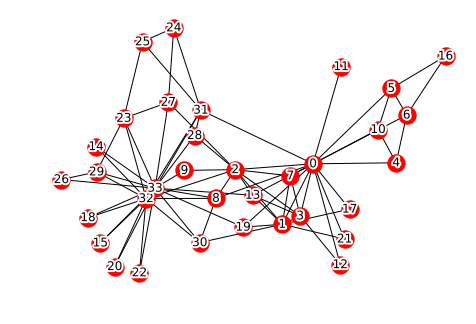

In [2]:
G = nx.karate_club_graph()
initial_communities = {d:i for i,d in enumerate(G.nodes())}
nx.draw(G,with_labels = True)
plt.show()

## Stage one - Original graph community assignment

In [3]:
def stage_one(G,max_iter = 30,communities = initial_communities):
    
    m = len(G.edges())
    
    # get nodes by community
    get_community_nodes = lambda x: [node for node, comm in communities.items() if comm == x]

    # degree lookup dictionary
    degrees = nx.degree(G)
    previous_altered_nodes = -1
    
    for iters in range(max_iter): 
        
        n_altered_nodes = 0
        
        # loop through all nodes, try reassign community labels
        for i in G.nodes():
            
            # number of edges connect to node i
            ki = degrees[i]
            # community label i belongs to
            ci = communities[i]
            
            # nodes inside community ci
            ci_nodes = get_community_nodes(ci)
            
            # number of edges i is connected to nodes inside ci
            kin = sum([1 if communities[v] == ci else 0 for u,v  in G.edges([i])])
            
            # sum of degress of nodes inside ci
            sig_tot = sum([degrees[jj] for jj in ci_nodes])
            
            # modularity change by remove i from its own community
            delta1 = (1/2*m) * (sig_tot * ki / m - kin)
            

            # find all neighbors
            neighbors =  G.neighbors(i)
            max_delta_q = -1
            c_target = ci
            # loop through all neighbbors
            for j in neighbors:

                # get community of a neighbor
                cj = communities[j]

                # get nodes from cj
                comm_nodes = get_community_nodes(cj)

                # edges connected 
                ki_in = sum([1 if communities[v] == cj else 0 for u,v in G.edges([i]) ])

                # sum of node degrees
                sigma_tot = sum([degrees[jj] for jj in comm_nodes])

                # calculate modularity increase
                delta_q = (1/(2*m))*( ki_in - (sigma_tot * ki) / m) + delta1


                if (delta_q > max_delta_q) & (delta_q > 0):
                    max_delta_q = delta_q
                    c_target = cj

            # assign community label
            communities[i] = c_target

            if ci != c_target:
                n_altered_nodes += 1
        
        
        if n_altered_nodes == previous_altered_nodes:
            break     
            
        previous_altered_nodes = n_altered_nodes
        
    return communities,degrees

In [4]:
communities,degrees = stage_one(G)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


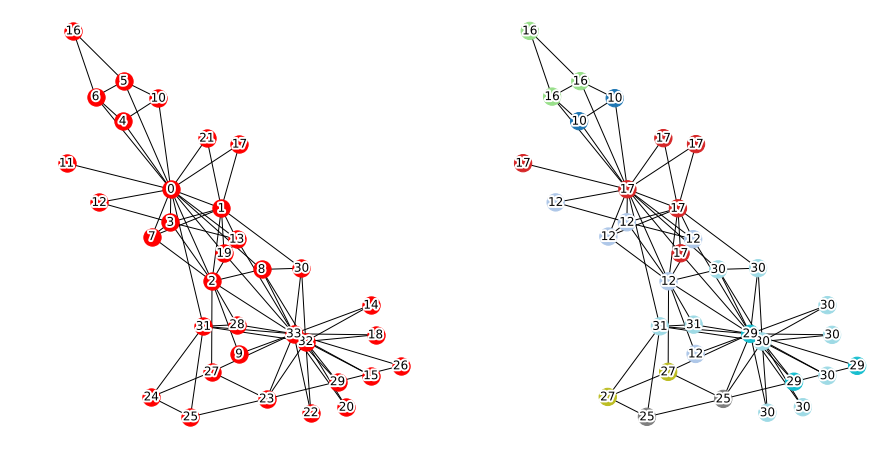

In [5]:
from IPython.core.pylabtools import figsize
figsize(15,8)
pos = nx.spring_layout(G)
plt.subplot(1,2,1)
nx.draw(G,with_labels = True,pos = pos)
plt.subplot(1,2,2)
# ,labels = {n:c for n,c in enumerate(communities.values())}
nx.draw(G,node_color=list(communities.values()),pos = pos,cmap = plt.get_cmap('tab20'),labels = {n:c for n,c in enumerate(communities.values())})
plt.show()

## Make Super-Graph

In [6]:
from collections import defaultdict

def make_super_graph(G,communities):

    degrees = nx.degree(G)

    # a super node is a collection of nodes in the same community from step1
    super_nodes = defaultdict(set)
    for k,v in communities.items():
        super_nodes[v].add(k)

    # super node weights are summ of inner degrees of sub nodes - community nodes
    super_node_weights = {}

    # loop through each super node
    for s, nodes in super_nodes.items():
        # loop through each sub node
        deg = 0
        for node in nodes:
            deg += sum([1 for u,v in G.edges([node]) if communities[u] == communities[v]])
        super_node_weights[s] = deg

    # weight of adjacent super nodes are defined by number of edges between them in original graph
    cross_weights = defaultdict(int)
    cross_edges = defaultdict(list)
    for u,v in G.edges():
        comm_u = communities[u]
        comm_v = communities[v]
        if comm_u != comm_v:
            cross_weights[(comm_u,comm_v)] += 1
            cross_edges[(comm_u,comm_v)].append([u,v])

    superG =  nx.Graph()

    # add nodes from step1 communities
    superG.add_nodes_from(list(super_nodes.keys()))

    # add edge between communities, weight being number of edges  between 2 communities
    for k,v in cross_weights.items():
        superG.add_edge(k[0],k[1],weight = v)

    # add self loop to super nodes, weight being number of 
    for k,v in super_node_weights.items():
        superG.add_edge(k,k,weight = v)
        
    return superG

In [7]:
superG = make_super_graph(G,communities)

**Just make a plot of the supernodes**

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


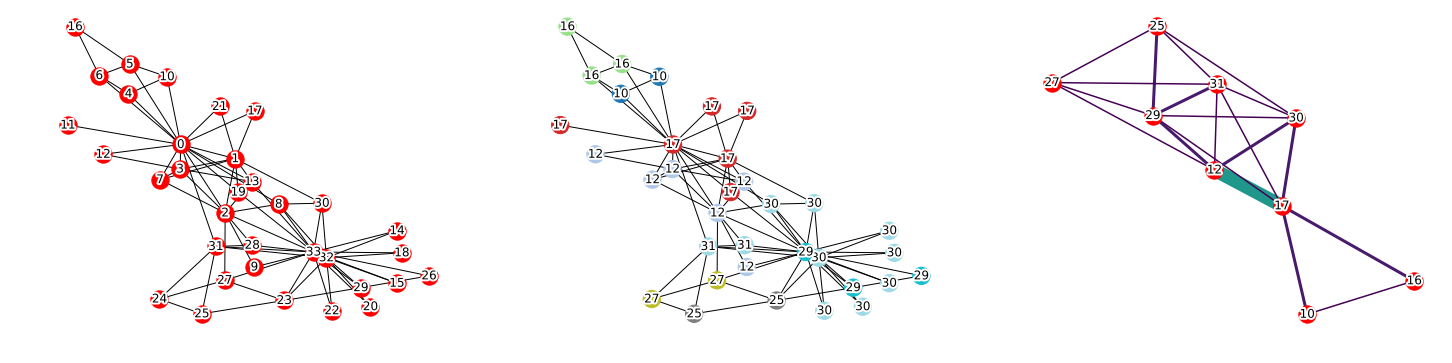

In [8]:
edges = superG.edges()
thickness = [d['weight']*1.5 for u,v,d in superG.edges(data = True)]

pos = pos
figsize(25,6)
plt.subplot(1,3,1)
nx.draw(G,with_labels = True,pos = pos)
plt.subplot(1,3,2)
nx.draw(G,node_color=list(communities.values()),pos = pos,cmap = plt.get_cmap('tab20'),labels = {n:c for n,c in enumerate(communities.values())})
plt.subplot(1,3,3)
nx.draw(superG,with_labels = True,width = thickness,edges = edges,edge_color=thickness,cmap = plt.get_cmap('tab20'),pos = nx.spring_layout(superG))
plt.show()

## Stage two - Super graph community assignment

In [9]:
def stage_two(superG,max_iter = 30):
    T = superG.copy()
    T_sl_removed =  T.copy()
    T_sl_removed.remove_edges_from(T_sl_removed.selfloop_edges())
    m = len(T.edges())

    # weights of the supernode selfloop
    degrees = {u:d['weight'] for u,v,d, in T.edges(data = True) if u == v}

    # assign communities of the supernodes
    communities = {d:i for i,d in enumerate(T.nodes())}

    # get nodes by community
    get_community_nodes = lambda x: [node for node, comm in communities.items() if comm == x]


    
    previous_altered_nodes = -1

    for iters in range(max_iter): 

        n_altered_nodes = 0

        # loop through all nodes, try reassign community labels
        for i in T.nodes():

            # number of edges connect to node i
            ki = degrees[i]
            # community label i belongs to
            ci = communities[i]

            # nodes inside community ci
            ci_nodes = get_community_nodes(ci)

            # number of edges i is connected to nodes inside ci
            kin = sum([d['weight'] if communities[v] == ci else 0 for u,v,d in T.edges([i],data = True) ])

            # sum of degress of nodes inside ci
            sig_tot = sum([degrees[jj] for jj in ci_nodes])

            # modularity change by remove i from its own community
            delta1 = (1/2*m) * (sig_tot * ki / m - kin)


            # find all neighbors
            neighbors =  T_sl_removed.neighbors(i)
            max_delta_q = -1
            c_target = ci


            # loop through all neighbbors
            for j in neighbors:

                # get community of a neighbor
                cj = communities[j]

                # get nodes from cj
                comm_nodes = get_community_nodes(cj)

                # edges connected 
                ki_in = sum([d['weight'] if communities[v] == cj else 0 for u,v,d in T.edges([i],data = True)])

                # sum of node degrees
                sigma_tot = sum([degrees[jj] for jj in comm_nodes])

                # calculate modularity increase
                delta_q = (1/(2*m))*( ki_in - (sigma_tot * ki) / m) #+ delta1

                if (delta_q > max_delta_q) & (delta_q > 0):
                    max_delta_q = delta_q
                    c_target = cj

            # assign community label
            communities[i] = c_target

            if ci != c_target:
                n_altered_nodes += 1

        if n_altered_nodes == 0:
            break
    return communities



In [10]:
super_communities = stage_two(superG)
super_communities

{17: 1, 12: 1, 10: 3, 16: 3, 30: 4, 25: 7, 27: 7, 29: 7, 31: 7}

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


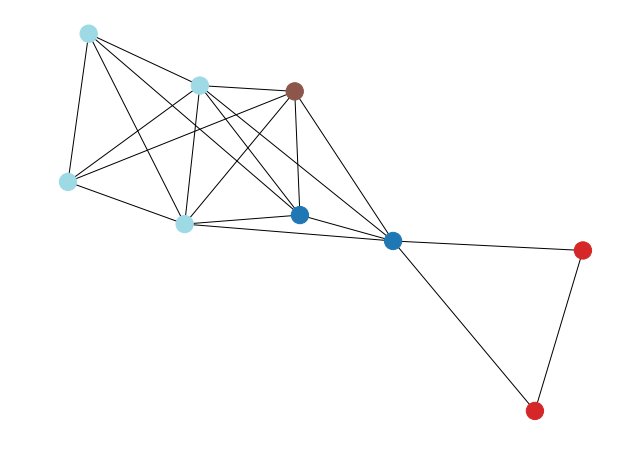

In [11]:
figsize(8,6)
nx.draw(superG,node_color=list(super_communities.values()),cmap = plt.get_cmap('tab20'))

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


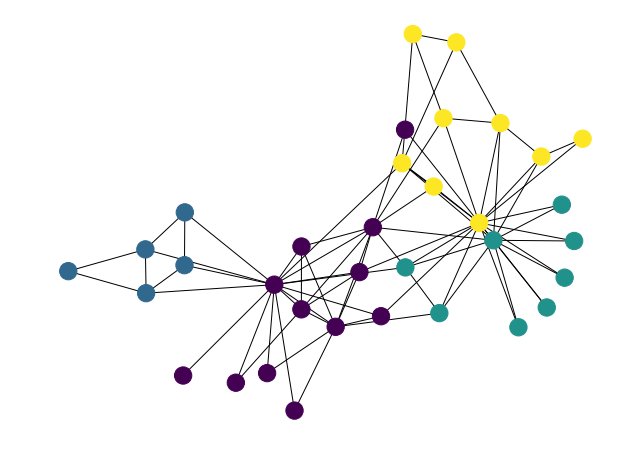

In [12]:
for node, comm in communities.items():
    communities[node] = super_communities[comm]
nx.draw(G,node_color = list(communities.values()))

## Louvain (Stop condition undefined)

In [13]:
def make_clique_type_graph(n_nodes = 300,n_comm =  4,in_comm_edges = 800,n_edges_cross_comms =  30):

    nodes = np.arange(0,n_nodes).tolist()
    nodes_comm =  int(len(nodes) / n_comm)
    comms = [nodes[i*nodes_comm:(i+1)*nodes_comm] for i in range(n_comm)]

    G = nx.Graph()
    for comm in comms:
        G.add_nodes_from(comm)
        for _ in range(in_comm_edges):
            u,v = np.random.choice(comm,2).tolist()
            G.add_edge(u,v)



    edges = []
    for comm1, comm2 in  combinations(range(len(comms)),2):
        for i in range(n_edges_cross_comms):
            edges.append([np.random.choice(comms[comm1]), np.random.choice(comms[comm2])])

    G.add_edges_from(edges)
    return G

In [14]:
def louvain_draw_communities(G):
    communities = {d:i for i,d in enumerate(G.nodes())}


    for _ in range(10):
        communities,degrees = stage_one(G,communities = communities,max_iter=3)
        superG = make_super_graph(G,communities)
        super_communities = stage_two(superG,max_iter=3)

        for node, comm in communities.items():
            communities[node] = super_communities[comm]


    nx.draw(G,node_color = list(communities.values()),pos = nx.spring_layout(G))
    plt.show()

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


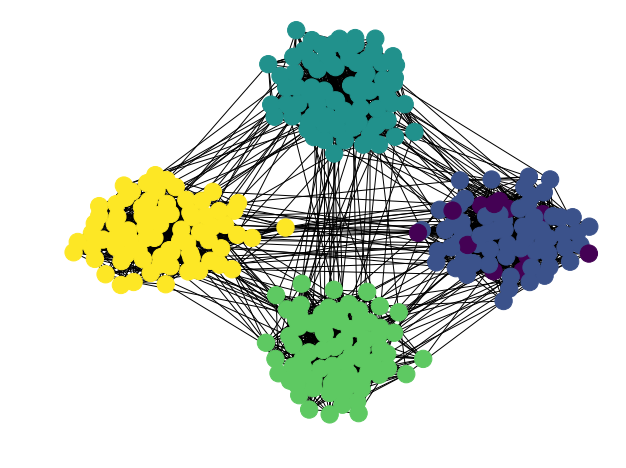

In [15]:
G = make_clique_type_graph()
louvain_draw_communities(G)